# ===========================================================
# Generating a supervised dataset from the Jeopardy-like logs
# ===========================================================

Goals:
1. Split the data into test and train
2. Formulate the convex optimization model
3. Compute train and test error

#### Last update: 03 Dec 2019

# Imports

In [471]:
from __future__ import division, print_function, absolute_import, unicode_literals

import cvxpy as cp
import scipy as sp
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import sys
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
sys.path.insert(0, '../src/')
%matplotlib inline

import utils
from mytimer import Timer

# Parameters

In [472]:
data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data.pk'
lambdaa = 0.1
test_fraction = 0.2
runs = 30

# Helper functions

In [473]:
def compute_matrix_err(true_matrix: np.matrix, pred_matrix: np.matrix, type_str: str = 'frob_norm') -> float:
    if type_str == 'frob_norm':
        frob_norm_of_difference = np.linalg.norm(true_matrix - pred_matrix)
        err = frob_norm_of_difference / np.linalg.norm(true_matrix)
        return err
    elif type_str == 'corr':
#         (r, p) = sp.stats.spearmanr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        (r, p) = sp.stats.pearsonr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        if p > 0.05:
            r = 0
        return r
    else:
        raise ValueError('Wrong type_str was given.')

# Loading the data

In [474]:
data = utils.load_it(data_fpath)
print(len(data['X']))

337


In [475]:
mats = []
for i in range(len(data['y'])):
    mats.append(data['y'][i]['influence_matrix'] / 100)

In [476]:
np.mean(mats, axis=0)

array([[0.26338279, 0.24830861, 0.25548961, 0.23243323],
       [0.2189911 , 0.33845697, 0.2158457 , 0.2227003 ],
       [0.21379822, 0.2511276 , 0.30367953, 0.22474777],
       [0.25338279, 0.24091988, 0.24379822, 0.26367953]])

In [477]:
np.std(mats, axis=0)

array([[0.12754406, 0.08032826, 0.09008641, 0.07827526],
       [0.10004831, 0.19647938, 0.08964129, 0.11201212],
       [0.09734972, 0.12308318, 0.17451618, 0.10372017],
       [0.0940633 , 0.06791981, 0.06305615, 0.09161002]])

# Formulating the convex optimization problem

In [478]:
all_networks = True
one_type_network = 'reply_duration'   # 'emotion_dominance'

## Hyperparameter tuning

In [479]:
with Timer():
    lambdaas = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9, 1, 2, 5, 10, 100, 1000, 10000]
    model_errs = defaultdict(list)

    for lambdaa in lambdaas:
        print('Lambda: ', lambdaa, '...')
        for run in range(runs):
            X_train, X_test, y_train, y_test = train_test_split(
                data['X'], data['y'], test_size=test_fraction)

            # Solving the optimization problem.
            if all_networks:
                W1 = cp.Variable(4, 4)
                W2 = cp.Variable(4, 4)
                W3 = cp.Variable(4, 4)
                W4 = cp.Variable(4, 4)
                W5 = cp.Variable(4, 4)
            else:
                W = cp.Variable(4, 4)
            B = cp.Variable(4, 4)

            constraints = []
            losses = 0
            for index in range(len(X_train)):
                element = X_train[index]
                influence_matrix = y_train[index]['influence_matrix'] / 100
                if all_networks:
                    A1 = element['reply_duration']
                    A2 = element['sentiment']
                    A3 = element['emotion_arousal']
                    A4 = element['emotion_dominance']
                    A5 = element['emotion_valence']
                    pred_influence_matrix = A1 * W1 + A2 * W2 + A3 * W3 + A4 * W4 + A5 * W5 + B
                else:
                    A = element[one_type_network]
                    D = np.diag(np.array(np.sum(A, axis=0))[0])
                    L = D - A
                    A = np.linalg.eig(L)[1]
                    pred_influence_matrix = A * W + B
                loss = pred_influence_matrix - influence_matrix
                losses += cp.sum_squares(loss)
                constraints += [pred_influence_matrix >= 0]
                constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]

            if all_networks:
                regluarization = cp.norm1(W1) + cp.norm1(W2) + cp.norm1(W3) + cp.norm1(W4) + cp.norm1(W5) + cp.norm1(B)
            else:
                regluarization = cp.norm1(W) + cp.norm1(B)

            objective = cp.Minimize(losses + lambdaa * regluarization)
            prob = cp.Problem(objective, constraints)
            result = prob.solve(solver=cp.MOSEK)

            model_err = 0
            for index in range(len(X_test)):
                element = X_test[index]
                influence_matrix = y_test[index]['influence_matrix'] / 100
                # Optimization model prediction:
                if all_networks:
                    A1 = element['reply_duration']
                    A2 = element['sentiment']
                    A3 = element['emotion_arousal']
                    A4 = element['emotion_dominance']
                    A5 = element['emotion_valence']
                    predicted_influence_matrix = (
                        A1 * W1.value + A2 * W2.value + A3 * W3.value + A4 * W4.value + A5 * W5.value + B.value)
                else:
                    A = element[one_type_network]
                    D = np.diag(np.array(np.sum(A, axis=0))[0])
                    L = D - A
                    A = np.linalg.eig(L)[1]
                    predicted_influence_matrix = A * W.value + B.value

                model_err += compute_matrix_err(
                    influence_matrix, predicted_influence_matrix)

            model_err /= len(X_test)
            model_errs[lambdaa].append(model_err)

Lambda:  0 ...
Lambda:  0.01 ...
Lambda:  0.05 ...
Lambda:  0.1 ...
Lambda:  0.2 ...
Lambda:  0.3 ...
Lambda:  0.5 ...
Lambda:  0.9 ...
Lambda:  1 ...
Lambda:  2 ...
Lambda:  5 ...
Lambda:  10 ...
Lambda:  100 ...
Lambda:  1000 ...
Lambda:  10000 ...
It took 10.03 minutes.


In [480]:
errz = []
for lambdaa in lambdaas:
    print(lambdaa, ': ', np.mean(model_errs[lambdaa]), '+-', np.std(model_errs[lambdaa]))
    errz.append(np.mean(model_errs[lambdaa]))

0 :  0.35608645871808486 +- 0.014620201341938461
0.01 :  0.3525696031799746 +- 0.011546194321296523
0.05 :  0.35785155088656234 +- 0.015976610117147984
0.1 :  0.35342285937833506 +- 0.014037538899800191
0.2 :  0.3503746350315483 +- 0.016777680793010556
0.3 :  0.355095004110407 +- 0.013981513840232104
0.5 :  0.35222848755710623 +- 0.01659744874979603
0.9 :  0.3524225679032608 +- 0.016713885730504925
1 :  0.34869908625814217 +- 0.015071770578701531
2 :  0.34946528183077546 +- 0.015278765441915086
5 :  0.347771733662158 +- 0.015323945622139727
10 :  0.349564298708072 +- 0.016278216528879706
100 :  0.35144890860441974 +- 0.01790923692654266
1000 :  0.345987153576825 +- 0.015598480912615627
10000 :  0.35229282318491634 +- 0.018514947623754975


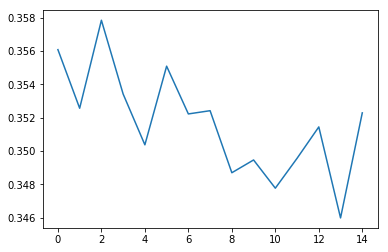

In [481]:
plt.plot(errz);

## Runs

In [482]:
lambdaa = 1000

In [483]:
model_errs = []
random_errs = []
uniform_errs = []

for run in range(runs):
    print('Run', run, '...')
    X_train, X_test, y_train, y_test = train_test_split(
        data['X'], data['y'], test_size=test_fraction)
    
    # Solving the optimization problem.
    with Timer():
        if all_networks:
            W1 = cp.Variable(4, 4)
            W2 = cp.Variable(4, 4)
            W3 = cp.Variable(4, 4)
            W4 = cp.Variable(4, 4)
            W5 = cp.Variable(4, 4)
        else:
            W = cp.Variable(4, 4)
        B = cp.Variable(4, 4)

        constraints = []
        losses = 0
        for index in range(len(X_train)):
            element = X_train[index]
            influence_matrix = y_train[index]['influence_matrix'] / 100
            if all_networks:
                A1 = element['reply_duration']
                A2 = element['sentiment']
                A3 = element['emotion_arousal']
                A4 = element['emotion_dominance']
                A5 = element['emotion_valence']
                pred_influence_matrix = A1 * W1 + A2 * W2 + A3 * W3 + A4 * W4 + A5 * W5 + B
            else:
                A = element[one_type_network]
                D = np.diag(np.array(np.sum(A, axis=0))[0])
                L = D - A
                A = np.linalg.eig(L)[1]
                pred_influence_matrix = A * W + B
            loss = pred_influence_matrix - influence_matrix
            losses += cp.sum_squares(loss)
            constraints += [pred_influence_matrix >= 0]
            constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]

        if all_networks:
            regluarization = cp.norm1(W1) + cp.norm1(W2) + cp.norm1(W3) + cp.norm1(W4) + cp.norm1(W5) + cp.norm1(B)
        else:
            regluarization = cp.norm1(W) + cp.norm1(B)

        objective = cp.Minimize(losses + lambdaa * regluarization)
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver=cp.MOSEK)
        print('It was {} and result was {}'.format(prob.status, result))

    model_err = 0
    random_err = 0
    uniform_err = 0
    for index in range(len(X_test)):
        element = X_test[index]
        influence_matrix = y_test[index]['influence_matrix'] / 100
        
        # Random model prediction:
        pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
            np.random.rand(4, 4)))
        random_err += compute_matrix_err(
            influence_matrix, pred_random_influence_matrix)
        
        # Uniform prediction:
        pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
        uniform_err += compute_matrix_err(
            influence_matrix, pred_uniform_influence_matrix)
        
        # Optimization model prediction:
        if all_networks:
            A1 = element['reply_duration']
            A2 = element['sentiment']
            A3 = element['emotion_arousal']
            A4 = element['emotion_dominance']
            A5 = element['emotion_valence']
            predicted_influence_matrix = (
                A1 * W1.value + A2 * W2.value + A3 * W3.value + A4 * W4.value + A5 * W5.value + B.value)
        else:
            A = element[one_type_network]
            D = np.diag(np.array(np.sum(A, axis=0))[0])
            L = D - A
            A = np.linalg.eig(L)[1]
            predicted_influence_matrix = A * W.value + B.value

        model_err += compute_matrix_err(
            influence_matrix, predicted_influence_matrix)
    #     err += frob_norm_of_difference
    model_err /= len(X_test)
    random_err /= len(X_test)
    uniform_err /= len(X_test)

    model_errs.append(model_err)
    random_errs.append(random_err)
    uniform_errs.append(uniform_err)

Run 0 ...
It was optimal and result was 4050.9757240486833
It took 1.33 seconds.
Run 1 ...
It was optimal and result was 4053.1066016004847
It took 1.40 seconds.
Run 2 ...
It was optimal and result was 4053.1591737505723
It took 1.23 seconds.
Run 3 ...
It was optimal and result was 4055.067193366064
It took 1.39 seconds.
Run 4 ...
It was optimal and result was 4053.784722134913
It took 1.40 seconds.
Run 5 ...
It was optimal and result was 4051.4541362128857
It took 1.23 seconds.
Run 6 ...
It was optimal and result was 4054.293284774624
It took 1.38 seconds.
Run 7 ...
It was optimal and result was 4052.2668185440098
It took 1.37 seconds.
Run 8 ...
It was optimal and result was 4052.21727014741
It took 1.25 seconds.
Run 9 ...
It was optimal and result was 4051.9623384449005
It took 1.38 seconds.
Run 10 ...
It was optimal and result was 4052.7345880959306
It took 1.24 seconds.
Run 11 ...
It was optimal and result was 4055.238828529121
It took 1.40 seconds.
Run 12 ...
It was optimal and re

random: 0.6385164146806789 +- 0.017046211137448752
uniform: 0.3536428640770363 +- 0.017370555497499492
model: 0.3535997550734507 +- 0.014817478563183436


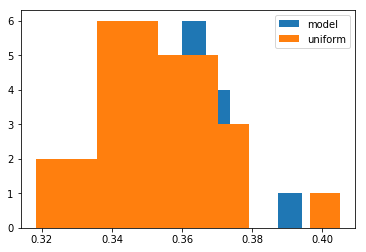

In [484]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

In [140]:
# # with Timer():
# #     W = cp.Variable(4, 4)
# #     B = cp.Variable(4, 4)

# #     lambdaa = 0.1

# #     constraints = []
# #     losses = 0
# #     for index in range(len(X_train)):
# #         element = X_train[index]
# #         influence_matrix = y_train[index]['influence_matrix'] / 100
# #         A = element['reply_duration']
# #         pred_influence_matrix = A * W + B
# #         loss = pred_influence_matrix - influence_matrix
# #     #     losses += cp.norm(loss, p=2)
# #         losses += cp.sum_squares(loss)
# #         constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]

# #     # regluarization = 0
# #     regluarization = cp.norm1(W) + cp.norm1(B)

# #     objective = cp.Minimize(losses + lambdaa * regluarization)
# #     prob = cp.Problem(objective, constraints)
# #     result = prob.solve(solver=cp.MOSEK)

It took 0.77 seconds.


In [167]:
# result

54.81053743316319

In [172]:
# err = 0
# for index in range(len(X_test)):
#     element = X_test[index]
#     influence_matrix = y_test[index]['influence_matrix'] / 100
#     A1 = element['reply_duration']
#     A2 = element['sentiment']
#     A3 = element['emotion_arousal']
#     A4 = element['emotion_dominance']
#     A5 = element['emotion_valence']
#     predicted_influence_matrix = (
#         A1 * W1.value + A2 * W2.value + A3 * W3.value + A4 * W4.value + A5 * W5.value + B.value)
#     frob_norm_of_difference = np.linalg.norm(predicted_influence_matrix - influence_matrix)
#     err += frob_norm_of_difference / np.linalg.norm(influence_matrix)
# #     err += frob_norm_of_difference
# err /= len(X_test)

In [173]:
# err

0.3401045431792546